# Vectorise raster prediction

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

The foolowing steps are executed to vectorise and spatially merge the vectors:

 * create a weights.tiff file, based on upscaled tiff dimension and overlap size
 * list tiffs that should be in the vrt (all tiffs should be from same UTM zone)
 * create vrt file
 * run process over whole area, split into small tiles:
    * for each row run:
        * extract small tiff file from vrt (gdal_transform)
        * contour it (gdal_contour)
        * merge extracted contours with existing merged tiles of the row
    * (run rows in multiprocess mode to speed up processing)
    * merge rows using the same approach
    
## Requirements

`gdal` version `>=2.4.0` is required for contouring the raster prediction. In addition, the following operations required the tiff files to be copied locally.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from fd.vectorisation import (
    VectorisationConfig,
    get_weights, 
    write_vrt, 
    spatial_merge_contours,
    run_vectorisation
)

## Showcase how workflow works on small subset

The following code showcases how the workflow operates on a small test. Skip this to run the workflow on the entire area. 

For test, you can download these two patches and run the following cells

In [3]:
vectorise_config = VectorisationConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    tiffs_folder='results/Castilla/2020-04/raster',
    time_intervals=['APRIL'],
    utms=['32629', '32630'],
    shape=(4400, 4400),
    buffer=(200, 200),
    weights_file='./cyl-weights.tiff',
    vrt_dir='./',
    predictions_dir='cyl-predictions/',
    contours_dir='cyl-contours/'
)

In [4]:
!mkdir {vectorise_config.predictions_dir} {vectorise_config.contours_dir}
!aws s3 cp s3://{vectorise_config.bucket_name}/{vectorise_config.tiffs_folder}/APRIL/30TWM_6_5-32630.tiff {vectorise_config.predictions_dir}
!aws s3 cp s3://{vectorise_config.bucket_name}/{vectorise_config.tiffs_folder}/APRIL/30TWM_6_6-32630.tiff {vectorise_config.predictions_dir}

download: s3://sinergise-niva/results/Castilla/2020-04/raster/APRIL/30TWM_6_5-32630.tiff to cyl-predictions/30TWM_6_5-32630.tiff
download: s3://sinergise-niva/results/Castilla/2020-04/raster/APRIL/30TWM_6_6-32630.tiff to cyl-predictions/30TWM_6_6-32630.tiff


#### Create a weights.tiff file, based on upscaled tiff dimension and overlap size

In [5]:
with rasterio.open(vectorise_config.weights_file, 'w', driver='gTIFF', 
                   width=vectorise_config.shape[0], height=vectorise_config.shape[1], 
                   count=1, dtype=np.float32) as dst:
    dst.write_band(1, get_weights(vectorise_config.shape, vectorise_config.buffer))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/rasterio/__init__.py:232: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


#### List upsampled tiffs

In [6]:
tifs = !ls {vectorise_config.predictions_dir}*tiff 
len(tifs)

2

#### Create VRT

In [7]:
write_vrt(tifs, vectorise_config.weights_file, f'{vectorise_config.vrt_dir}/output.vrt')

In [9]:
# this code will produce a (possibly extremely large) GeoTIFF
# use with caution!

def vrt2tiff(vrt, tiff):
    with rasterio.Env(GDAL_VRT_ENABLE_PYTHON=True):
        with rasterio.open(vrt, 'r') as src:
            meta = src.meta
            data = src.read(1)
            meta.update(driver='gTiff')

            with rasterio.open(tiff,'w', **meta) as dst:
                dst.write(data, 1)

In [8]:
# vrt2tiff(output_vrt, 'output_test.tiff')

#### Contouring and merging contours

In [8]:
%%time
all_in_one = spatial_merge_contours(vrt_file=f'{vectorise_config.vrt_dir}/output.vrt', 
                                    contours_dir=vectorise_config.contours_dir, 
                                    max_workers=vectorise_config.max_workers,
                                    size=vectorise_config.chunk_size, 
                                    buffer=vectorise_config.chunk_overlap, 
                                    threshold=vectorise_config.threshold,
                                    skip_existing=vectorise_config.skip_existing, 
                                    cleanup=vectorise_config.cleanup, 
                                    rows_merging=vectorise_config.rows_merging)


CPU times: user 11.3 s, sys: 52 ms, total: 11.4 s
Wall time: 31.2 s


In [9]:
len(all_in_one)

3790

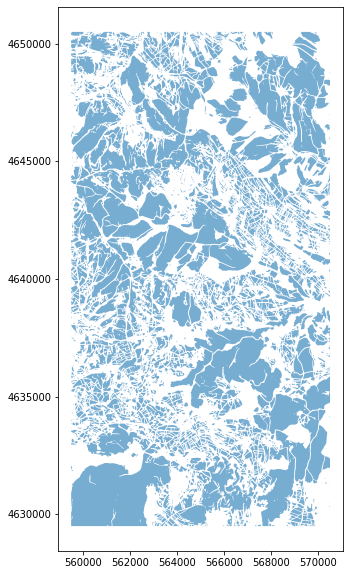

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
all_in_one.plot(ax=ax, alpha=0.6)

# Run vectorisation on all predictions 

To speed up the processing, the following is implemented:

 * run the contouring per row first, which uses multiprocessing
 * run the merging of the rows in multiprocessing
 

In [3]:
vectorisation_config = VectorisationConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    tiffs_folder='results/Castilla/2020-04/raster',
    time_intervals=['APRIL'],
    utms=['32629', '32630'],
    shape=(4400, 4400),
    buffer=(200, 200),
    weights_file='/home/ubuntu/cyl-weights.tiff',
    vrt_dir='/home/ubuntu/',
    predictions_dir='/home/ubuntu/cyl-predictions',
    contours_dir='/home/ubuntu/cyl-contours',
    max_workers=20
)

In [ ]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

In [ ]:
list_of_merged_files = run_vectorisation(vectorisation_config)

In [5]:
list_of_merged_files

['/home/ubuntu/cyl-contours/merged_APRIL_32629.gpkg',
 '/home/ubuntu/cyl-contours/merged_APRIL_32630.gpkg']